In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import conv2d, conv3d
from scipy.ndimage import convolve, generate_binary_structure
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Required Facts

A system in thermal equilibrium with a temperature bath. Probability $p_\mu$ of being in state $\mu$ with energy $E_\mu$ is

 $$p_\mu = \frac{1}{Z} e^{-\beta E_\mu} $$
 
where $Z = \sum_\mu e^{-\beta E_\mu}$ is the **partition function**. At equilbrium, the following must be true

$$\sum_\nu p_\mu P(\mu \to \nu) = \sum_\nu p_\nu P(\nu \to \mu)$$

where $P(\mu \to \nu)$ is the probability of going from state $\mu$ to $\nu$. For our numerical methods, this is difficult to enforce, but we can make it be true be setting the **detailed balance condition**

$$p_\mu P(\mu \to \nu) =p_\nu P(\nu \to \mu)$$

This true when

$$\frac{P(\mu \to \nu)}{P(\nu \to \mu)} = \frac{p_\nu}{p_\mu} = e^{-\beta (E_\nu-E_\mu)}$$


<p align="center">
  <img src="../images/vid14_p1.PNG" alt="drawing" width="400" align="center"/>
</p>


# Ising Model

The Ising model is a model of magnetization and gives us the energies needed to to evaluate the equation above

<p align="center">
  <img src="../images/vid14_p2.PNG" alt="drawing" width="300" align="center"/>
</p>

The total energy is

$$E_\mu = \sum_i \sum_{j \in N_i} -J\sigma_i \sigma_j $$

where 

* $i$ corresponds to the index of a point in the lattice
* $N_i$ is a set of indices corresponding to the nearest neighbours to that point. In 2D, there are 4 neighbours (left/right, above/below) and in 3D there are 6 neighbours (also front/back)
* $\sigma_i$ is the spin (-1 or +1) of point $i$
* $\mu$ corresponds to a particular configuration of the spins.


# Metropolis Algorithm

**The Idea**: We want this to hold:

$$\frac{P(\mu \to \nu)}{P(\nu \to \mu)} = \frac{p_\nu}{p_\mu} = e^{-\beta (E_\nu-E_\mu)}$$

We'll simulate the system changing states from $\mu$ to different states $\nu$ at equilibrium, but we need to enforce the equation above.

1. Call the current state $\mu$. 
2. Pick a random particle on the lattice and flip the spin sign. Call the state $\nu$. We want to find the probability that $P(\mu \to \nu)$ that we'll accept this new state
3. * If $E_\nu > E_\mu$ then set $P(\nu \to \mu) = 1$ and thus by the detailed balance equation $P(\mu \to \nu) = e^{-\beta (E_\nu-E_\mu)}$. 
    * if $E_\mu > E_\nu$ then the rule above implies $P(\mu \to \nu) = 1$
4. Change to state $\nu$ (i.e. flip the spin of the particle) with the probabilities outlined above. 
5. Go back to step 1. Repeat the whole thing many many times and eventually you'll force out an equilbrium state. 

In [3]:
# 1000 by 1000 grid
N = 1000

Generate some initial random grids of spins

In [4]:
init_random = torch.rand((N,N)).to(device)
lattice_n = torch.zeros((N, N)).to(device)
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

init_random = torch.rand((N,N)).to(device)
lattice_p = torch.zeros((N, N)).to(device)
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

Show initial lattice of spins

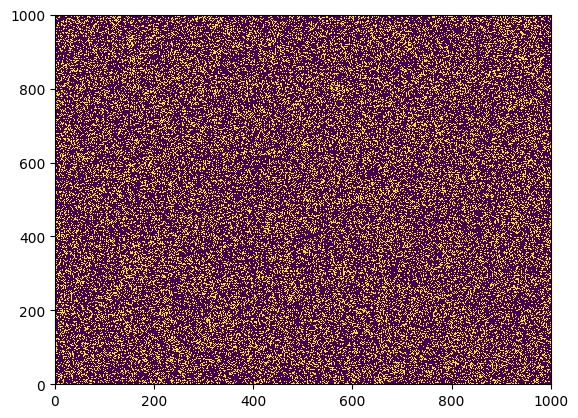

In [6]:
plt.pcolormesh(lattice_n.cpu())
plt.show()

Functions to compute

* the energy ( $E_i/J = -\sum_{j \in N_i} \sigma_i\sigma_j$) for each element $i$ in the lattice
* the total energy ( $E/J = -\sum_i \sum_{j \in N_i} \sigma_i\sigma_j$)of the lattice
* the change in energy ($\Delta E/J =  -2\sum_{j \in N_i} \sigma_i\sigma_j$) for each element in the lattice (if the spin were to flip)

Note that since we're using PyTorch's `conv2d` function, we have to be very careful about the input and kernel dimensionality:

* The first argument (input) has shape `[batch_size, in_channels, H, W]`
* The second argument (weight) has shape `[out_channels, in_channels, H, W]`

In our case, we aren't mixing over channels, so `in_channels=out_channels=`. The batch size we can use to our advantage if we want to perform convolutions over multiple lattices at the same time.

In [11]:
kern = generate_binary_structure(2, 1) 
kern[1][1] = False
kern

array([[False,  True, False],
       [ True, False,  True],
       [False,  True, False]])

In [12]:
kern = torch.tensor(kern.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
kern.shape

torch.Size([1, 1, 3, 3])

In [20]:
def get_energy_arr(lattices):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    kern = torch.tensor(kern.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    arr = -lattices * conv2d(lattices, kern, padding='same')
    return arr
    
def get_energy(lattices):
    # applies the nearest neighbours summation
    return get_energy_arr(lattices).sum(axis=(1,2,3))

def get_dE_arr(lattices):
    return -2*get_energy_arr(lattices)

We can create a batch of lattices corresponding to the two lattices we created above

In [21]:
lattices = torch.stack([lattice_n, lattice_p]).unsqueeze(dim=1)
lattices.shape

torch.Size([2, 1, 1000, 1000])

We can now compute the energy for these two lattices at the same time, since they have the necessary shape for feeding into the `get_energy_arr` algorithm

In [22]:
get_energy_arr(lattices).shape

torch.Size([2, 1, 1000, 1000])

In [23]:
get_energy(lattices).shape

torch.Size([2])

**The metropolis algorithm**:

* Takes in a batch of 2D tensors of spins (shape `[batch_size, 1, H, W]`), number of time steps to run algoritm for, and temperatures $\beta J$ of length `batch_size` corresponding to the temperature for each 2D lattice
* Returns the spin and energy as a function of iteration number for each lattice

In [24]:
def metropolis(spin_tensor_batch, times, BJs):
    energies = []
    avg_spins = []
    spin_tensor_batch = torch.clone(spin_tensor_batch)
    BJs = BJs.reshape([-1,1,1,1])
    for t in range(times):
        i = np.random.randint(0,2)
        j = np.random.randint(0,2)
        dE = get_dE_arr(spin_tensor_batch)[:,:,i::2,j::2]
        change = (dE>=0)*(torch.rand(dE.shape).to(device) < torch.exp(-BJs*dE)) + (dE<0)
        spin_tensor_batch[:,:,i::2,j::2][change] *=-1
        energies.append(get_energy(spin_tensor_batch))
        avg_spins.append(spin_tensor_batch.sum(axis=(1,2,3))/N**2)
    return torch.vstack(avg_spins), torch.vstack(energies)

Get the spins and energies

In [25]:
BJs = 0.5*torch.ones(lattices.shape[0]).to(device)
spins, energies = metropolis(lattices, 1000, BJs)

In [26]:
spins.shape

torch.Size([1000, 2])

Plot as a function of iteration number

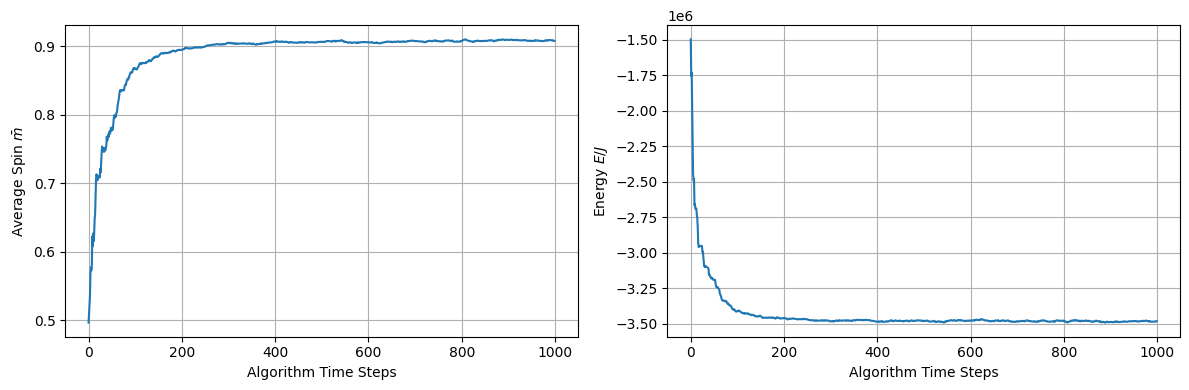

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins[:,1].cpu())
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies[:,1].cpu())
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
plt.show()

We can get $\bar{m}$ and $E/J$ for many different values of $\beta J$. The values will be the average of the last 100 points on the figure above.

In [33]:
def get_spin_energy(lattice, BJs):
    lattices = lattice.unsqueeze(dim=0).repeat(len(BJs),1,1,1)
    spins, energies = metropolis(lattices, 1000, BJs)
    spins_avg = torch.mean(spins[-400:], axis=0)
    energies_avg = torch.mean(energies[-400:], axis=0)
    energies_std = torch.std(energies[-400:], axis=0)
    return spins_avg, energies_avg, energies_std

BJs = 1/torch.linspace(1, 3, 20).to(device)
spins_avg_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
spins_avg_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

Can look at $\bar{m}$ as a function of temperature $T = 1/\beta k = J/(\beta J)k$

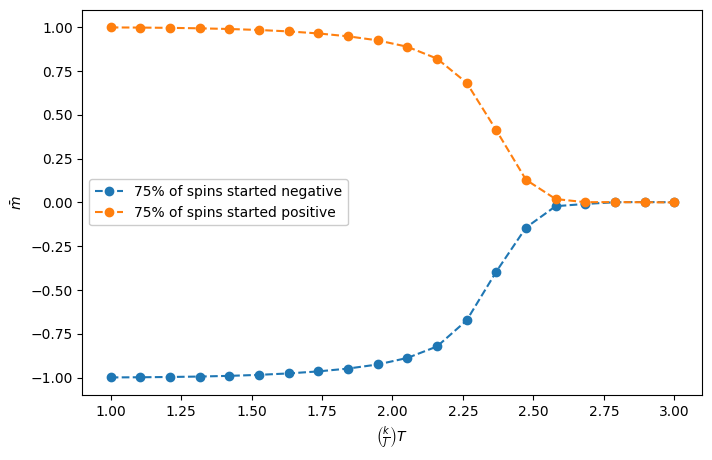

In [34]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs.cpu(), spins_avg_n.cpu(), 'o--', label='75% of spins started negative')
plt.plot(1/BJs.cpu(), spins_avg_p.cpu(), 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

# The 3D Ising Model

Because we're in 3D, we need to significantly reduce the size of our lattice.

In [35]:
N = 150

Create the initial lattice like before

In [36]:
init_random = torch.rand((N,N,N)).to(device)
lattice_p = torch.zeros((N,N,N)).to(device)
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

Functions to compute the energy for each element in the lattice, the total energy of the lattice, and $\Delta E$ for each element in the lattice (if the spin were to flip)

In [37]:
def get_energy_arr(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(3, 1) 
    kern[1][1][1] = False
    kern = torch.tensor(kern.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    arr = -lattice * conv3d(lattice, kern, padding='same')
    return arr
    
def get_energy(lattice):
    # applies the nearest neighbours summation
    return get_energy_arr(lattice).sum(axis=(2,3,4)).squeeze()

def get_dE_arr(lattice):
    return -2*get_energy_arr(lattice)

Create a batch of initial lattices to be ran in the metropolis function/

In [39]:
lattices = torch.stack([lattice_p, lattice_p]).unsqueeze(dim=1)

In [41]:
lattices.shape

torch.Size([2, 1, 150, 150, 150])

The metropolis function in 3D

In [42]:
def metropolis(spin_tensor_batch, times, BJs):
    energies = []
    avg_spins = []
    spin_tensor_batch = torch.clone(spin_tensor_batch)
    BJs = BJs.reshape([-1,1,1,1,1])
    for t in range(times):
        i = np.random.randint(0,2)
        j = np.random.randint(0,2)
        k = np.random.randint(0,2)
        dE = get_dE_arr(spin_tensor_batch)[:,:,i::2,j::2,k::2]
        change = (dE>=0)*(torch.rand(dE.shape).to(device) < torch.exp(-BJs*dE)) + (dE<0)
        spin_tensor_batch[:,:,i::2,j::2,k::2][change] *=-1
        energies.append(get_energy(spin_tensor_batch))
        avg_spins.append(spin_tensor_batch.sum(axis=(1,2,3,4))/N**3)
    return torch.vstack(avg_spins), torch.vstack(energies)

This function takes in an initial 3D lattice, and solves for average spin and energy at all the different temperatures specified by the $\beta J$ array values

In [43]:
def get_spin_energy(lattice, BJs):
    lattices = lattice.unsqueeze(dim=0).repeat(len(BJs),1,1,1,1)
    spins, energies = metropolis(lattices, 1000, BJs)
    spins_avg = torch.mean(spins[-400:], axis=0)
    energies_avg = torch.mean(energies[-400:], axis=0)
    energies_std = torch.std(energies[-400:], axis=0)
    return spins_avg, energies_avg, energies_std

Get temperatures and statistics

In [44]:
BJs = 1/torch.linspace(3, 5.5, 20).to(device)
spins_avg_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

According to https://arxiv.org/abs/2205.12357 (page 5) the accepted value for the critical temperature in the 3D Ising model is $\beta J = 0.221654626$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


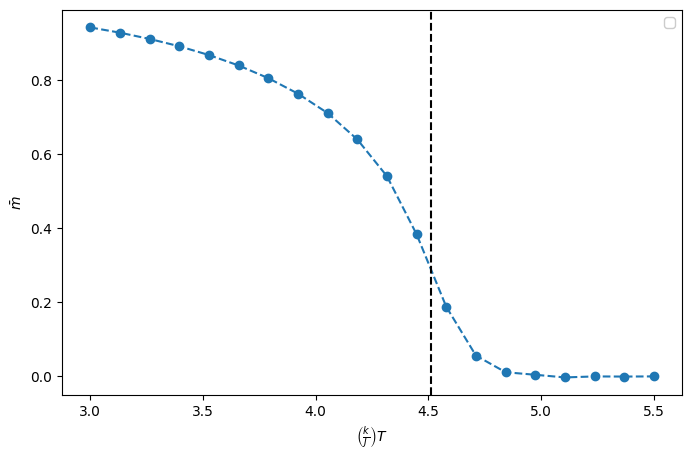

In [45]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs.cpu(), spins_avg_p.cpu(), 'o--')
plt.axvline(1 / 0.221654626, color='k', ls='--')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()